## Notebook for examining models individually

In [5]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt

In [85]:
prescription = "linear_homoskedastic"
dim = "2D"
inject_type = "feature"
noise = "high"
model = "DER"
m = 0
epoch = 99
size_df = 1000

In [86]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
checkpoints = AggregateCheckpoints()

In [88]:
path = "../DeepUQResources/checkpoints/"
if model == "DER":
    setupmodel, lossFn = model_setup_DER(
        model, DEVICE, n_hidden=64, data_type=dim)
    loss = "DER"
    COEFF = 0.01
    file_name = (
        str(path)
        + f"{model}_{prescription}_{inject_type}_{dim}"
        + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
    )
    file_name += f"_sizedf_{size_df}"
    file_name += ".pt"
    chk = torch.load(file_name, map_location=DEVICE)
elif model == "DE":
    loss = "bnll_loss"
    setupmodel, lossFn = model_setup_DE(
                        loss, DEVICE, n_hidden=64, data_type=dim)
    BETA = 0.5
    file_name = (
        str(path) +
        f"{model}_{prescription}_{inject_type}_{dim}"
        f"_noise_{noise}_beta_{BETA}_nmodel_{m}_epoch_{epoch}"
    )
    file_name += f"_sizedf_{size_df}"
    file_name += ".pt"
    chk = torch.load(file_name, map_location=DEVICE)

In [89]:
# define the model at this epoch
setupmodel.load_state_dict(chk.get("model_state_dict"))
# checkpoint['model_state_dict'])
setupmodel.eval()

Sequential(
  (0): ConvLayers(
    (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Model(
    (model): Sequential(
      (0): Linear(in_features=360, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (2): DERLayer()
)

In [90]:
data = DataPreparation()
sigma = DataPreparation.get_sigma(
                    noise, inject_type=inject_type, data_dimension=dim)
if dim == "0D":
    data.sample_params_from_prior(size_df)
    if inject_type == "feature":
        data.simulate_data(
            data.params,
            noise,
            "linear_homoskedastic",
            inject_type=inject_type,
            seed=41,
            vary_sigma=True,
        )
    else:
        data.simulate_data(
            data.params,
            sigma,
            "linear_homoskedastic",
            inject_type=inject_type,
            seed=41,
        )
    df_array = data.get_dict()
    # Convert non-tensor entries to tensors
    df = {}
    for key, value in df_array.items():

        if isinstance(value, TensorDataset):
            # Keep tensors as they are
            df[key] = value
        else:
            # Convert lists to tensors
            df[key] = torch.tensor(value)
    len_df = len(df["params"][:, 0].numpy())
    len_x = np.shape(df["output"])[1]
    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))

    inputs = np.array([xs_array, ms_array, bs_array]).T
    model_inputs = inputs
    model_outputs = ys_array
elif dim == "2D":
    data.sample_params_from_prior(
        size_df,
        low=[0, 1, -1.5],
        high=[0.5, 10, 1.5],
        n_params=3,
        seed=41)
    model_inputs, model_outputs = data.simulate_data_2d(
        size_df,
        data.params,
        image_size=32,
        inject_type=inject_type,
        sigma=sigma)
x_test = model_inputs
y_test = model_outputs

In [91]:
y_pred = setupmodel(
    torch.Tensor(x_test
        )
    ).detach().numpy()

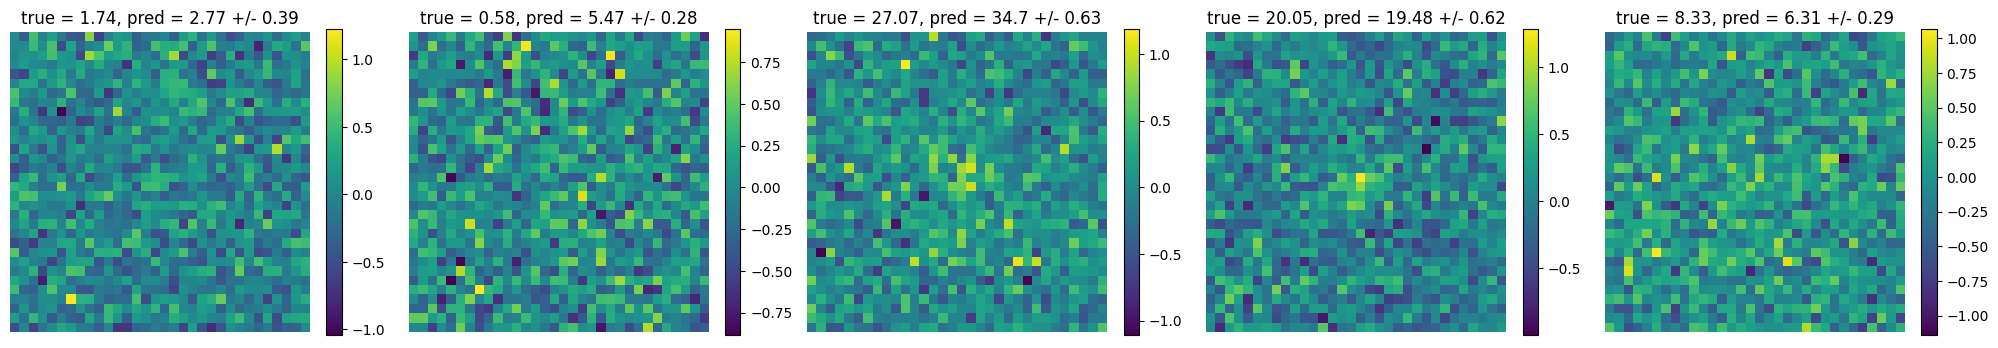

In [92]:
if dim == "2D":
    # Create a figure with 5 subplots in a horizontal row
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figsize as needed
    
    # Loop through each subplot
    for i in range(5):
        ax = axes[i]
        ax.imshow(x_test[i, :, :], aspect='auto')
        mu = round(y_pred[i,0],2)
        sig = round(np.sqrt(y_pred[i,1]),2)
        ax.set_title('true = '+str(round(y_test[i],2))
                     +', pred = '+str(mu)+' +/- '+str(sig))
        ax.figure.colorbar(ax.images[0], ax=ax, fraction = 0.046)
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Show the complete figure
    plt.tight_layout()
elif dim == "0D":
    plt.scatter(
            y_test,
            y_pred[:, 0],
            #color=color_list[i],
            #label=r"$\sigma = $" + str(sigma_list[i]),
            s=3,
        )
    plt.xlabel('true value')
    plt.ylabel('predicted value')
plt.savefig(f'../../../Desktop/validation_{model}_{noise_level}_{inject_type}_{dim}.png', dpi=1000)

Make a plot of residuals for the test set.

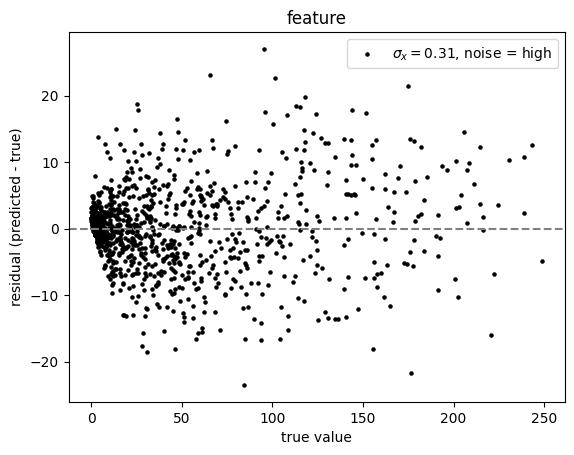

In [93]:
plt.scatter(
            y_test,
            (y_pred[:, 0] - y_test), # / outputs_test,
            color='black',
            #color=color_list[i],
            label=r"$\sigma_x = $" + str(round(sigma,2)) + ", noise = "+noise,
            s=5,
        )
plt.axhline(y=0, ls='--', color='grey')
plt.xlabel('true value')
plt.ylabel('residual (predicted - true)') #/ true')
plt.title(inject_type)
plt.legend()
plt.savefig(f'../../../Desktop/residuals_test_{model}_{noise_level}_{inject_type}_{dim}.png', dpi=1000)

Make it a panel plot.

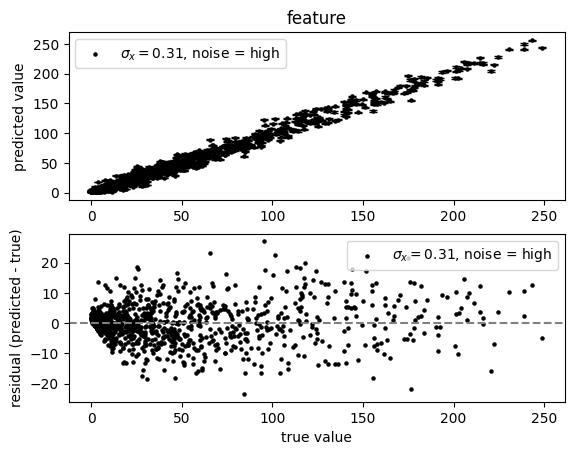

In [98]:
fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.errorbar(
            y_test,
            y_pred[:, 0],
            yerr=np.sqrt(y_pred[:,1]),
            color='black',
            #color=color_list[i],
            capsize=3,
            ls='None'
        )
ax0.scatter(
            y_test,
            (y_pred[:, 0]), # / outputs_test,
            color='black',
            #color=color_list[i],
            label=r"$\sigma_x = $" + str(round(sigma,2)) + ", noise = "+noise,
            s=5,
        )
ax1 = fig.add_subplot(212)
ax1.scatter(
            y_test,
            (y_pred[:, 0] - y_test), # / outputs_test,
            color='black',
            #color=color_list[i],
            label=r"$\sigma_x = $" + str(round(sigma,2)) + ", noise = "+noise,
            s=5,
        )
ax1.axhline(y=0, ls='--', color='grey')
ax1.set_xlabel('true value')
ax0.set_ylabel('predicted value')
ax1.set_ylabel('residual (predicted - true)') #/ true')
ax0.set_title(inject_type)
ax0.legend()
ax1.legend()
plt.savefig(f'../../../Desktop/parity_and_residuals_test_{model}_{noise_level}_{inject_type}_{dim}.png', dpi=1000)

What about making a loss plot with epoch?

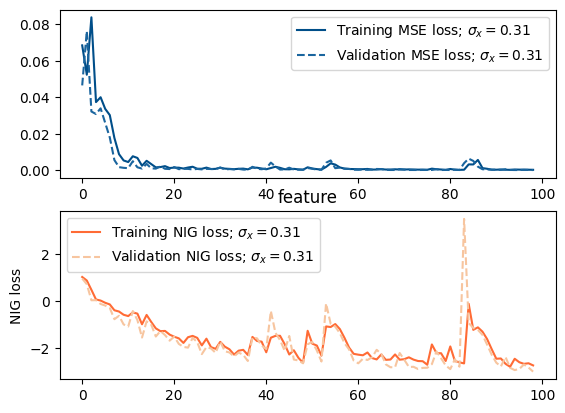

In [99]:
fig = plt.figure()
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)

color_list = ['#004E89','#1A659E','#FF6B35','#F7C59F']
mse_loss = []
loss_value = []
train_mse_loss = []
train_loss = []
for e in range(epoch):
    file_name = (
        str(path)
        + f"{model}_{prescription}_{inject_type}_{dim}"
        + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{e}"
    )
    file_name += f"_sizedf_{size_df}"
    file_name += ".pt"
    chk = torch.load(file_name, map_location=DEVICE)
    mse_loss.append(chk["valid_mse"])
    loss_value.append(chk["valid_loss"])
    train_mse_loss.append(chk["train_mse"])
    train_loss.append(chk["train_loss"])
ax0.plot(
        range(epoch),
        train_mse_loss,
        color=color_list[0],
        label=r"Training MSE loss; $\sigma_x = $" + str(round(sigma,2)),
        #s=5,
    )
ax0.plot(
        range(epoch),
        mse_loss,
        color=color_list[1],
        label=r"Validation MSE loss; $\sigma_x = $" + str(round(sigma,2)),
        ls = '--'
        #s=5,
    )
if model == "DER":
    ax1.plot(
            range(epoch),
            train_loss,
            color=color_list[2],
            label=r"Training NIG loss; $\sigma_x = $" + str(round(sigma,2)),
            #s=5,
        )
    ax1.plot(
            range(epoch),
            loss_value,
            color=color_list[3],
            label=r"Validation NIG loss; $\sigma_x = $" + str(round(sigma,2)),
            ls = '--'
            #s=5,
        )
elif model == "DE":
    ax1.plot(
            range(epoch),
            train_loss,
            color=color_list[2],
            label=r"Training $\beta$NLL loss; $\sigma_x = $" + str(round(sigma,2)),
            #s=5,
        )
    ax1.plot(
            range(epoch),
            loss_value,
            color=color_list[3],
            label=r"Validation $\beta$NLL loss; $\sigma_x = $" + str(round(sigma,2)),
            ls = '--'
            #s=5,
        )


plt.ylabel('MSE loss') #/ true')
plt.ylabel('NIG loss')
plt.title(inject_type)
ax0.legend() 
ax1.legend()
plt.savefig(f'../../../Desktop/loss_{model}_{noise_level}_{inject_type}_{dim}.png', dpi=1000)

Print down the final loss value.

In [100]:
print(f'Training loss final epoch: {train_loss[-1]}')
print(f'Validation loss final epoch: {loss_value[-1]}')
print(f'Training MSE loss final epoch: {train_mse_loss[-1]}')
print(f'Validation MSE loss final epoch: {mse_loss[-1]}')

Training loss final epoch: -2.725218507978651
Validation loss final epoch: -2.989877939224243
Training MSE loss final epoch: 0.00022960569023982517
Validation MSE loss final epoch: 0.0001011396452668123
